In [1]:
import math
import matplotlib.pyplot as plt
import keras
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import *
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

!pip install yfinance
import yfinance as yf

     |████████████████████████████████| 5.5MB 17.7MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22616 sha256=095c964520cc4a6df4400bbbf4452eddc0db40eabe93fa157876699a919734ba
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


In [2]:
df = pd.read_csv('OHLCVs.csv')
df.iloc[::-1]
print(df.columns)

open_close = df[['open', 'close']]

num_features = 2
num_train = 40000
num_test = 4535

training_set = open_close.iloc[:num_train].values
test_set = open_close.iloc[num_train:].values

df.head

Index(['date', 'open', 'high', 'low', 'close', 'volume', 'price', 'count',
       'instrument', 'exchange', 'pair'],
      dtype='object')


<bound method NDFrame.head of                       date      open      high  ...    instrument  exchange     pair
0      2020-09-03 23:59:00  10189.44  10195.89  ...  cbse/btc-usd      cbse  btc-usd
1      2020-09-03 23:58:00  10202.01  10224.04  ...  cbse/btc-usd      cbse  btc-usd
2      2020-09-03 23:57:00  10227.28  10227.28  ...  cbse/btc-usd      cbse  btc-usd
3      2020-09-03 23:56:00  10212.97  10245.01  ...  cbse/btc-usd      cbse  btc-usd
4      2020-09-03 23:55:00  10273.44  10273.72  ...  cbse/btc-usd      cbse  btc-usd
...                    ...       ...       ...  ...           ...       ...      ...
44530  2020-08-04 00:04:00  11260.69  11267.22  ...  cbse/btc-usd      cbse  btc-usd
44531  2020-08-04 00:03:00  11263.26  11263.37  ...  cbse/btc-usd      cbse  btc-usd
44532  2020-08-04 00:02:00  11247.96  11267.22  ...  cbse/btc-usd      cbse  btc-usd
44533  2020-08-04 00:01:00  11235.49  11248.89  ...  cbse/btc-usd      cbse  btc-usd
44534  2020-08-04 00:00:00  11233.1

In [3]:
# Feature Scaling
sc = MinMaxScaler(feature_range = (0, 1))
training_set_scaled = sc.fit_transform(training_set)

# Creating a data structure with 60 time-steps and 1 output
X_train = []
y_train = []
for i in range(60, num_train):
    X_train.append(training_set_scaled[i-60:i, 0:num_features])
    y_train.append(training_set_scaled[i, 1])
X_train, y_train = np.array(X_train), np.array(y_train)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], num_features))

In [4]:
model = Sequential()
#Adding the first LSTM layer and some Dropout regularisation
model.add(Bidirectional(LSTM(units = 50, input_shape = (X_train.shape[1], num_features))))
model.add(Dropout(0.2))
# Adding the output layer
model.add(Dense(units = 1))

In [5]:
# Compiling the RNN
model.compile(optimizer = 'adam', loss = 'mean_squared_error')

# Fitting the RNN to the Training set
model.fit(X_train, y_train, epochs = 30, batch_size = 32)
model.summary()

Epoch 1/30
1249/1249 [==============================] - 17s 7ms/step - loss: 0.0264
Epoch 2/30
1249/1249 [==============================] - 9s 7ms/step - loss: 0.0013
Epoch 3/30
1249/1249 [==============================] - 9s 7ms/step - loss: 9.3806e-04
Epoch 4/30
1249/1249 [==============================] - 9s 7ms/step - loss: 6.6429e-04
Epoch 5/30
1249/1249 [==============================] - 9s 7ms/step - loss: 4.2468e-04
Epoch 6/30
1249/1249 [==============================] - 8s 7ms/step - loss: 2.4653e-04
Epoch 7/30
1249/1249 [==============================] - 8s 7ms/step - loss: 1.5497e-04
Epoch 8/30
1249/1249 [==============================] - 9s 7ms/step - loss: 1.0680e-04
Epoch 9/30
1249/1249 [==============================] - 9s 7ms/step - loss: 8.9698e-05
Epoch 10/30
1249/1249 [==============================] - 8s 7ms/step - loss: 7.9898e-05
Epoch 11/30
1249/1249 [==============================] - 8s 7ms/step - loss: 7.5568e-05
Epoch 12/30
1249/1249 [=========================

In [6]:
# Getting the predicted stock price
dataset_train = open_close.iloc[:num_train]
dataset_test = open_close.iloc[num_train:]
dataset_total = pd.concat((dataset_train, dataset_test), axis = 0)
inputs = dataset_total[len(dataset_total) - len(dataset_test) - 60:].values
inputs = inputs.reshape(-1,num_features)
inputs = sc.transform(inputs)

X_test = []
for i in range(60, num_test+60):
    X_test.append(inputs[i-60:i, 0:num_features])
X_test = np.array(X_test)
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], num_features))

In [7]:
predicted_stock_price = model.predict(X_test)
predicted_padded = np.zeros(shape=(len(predicted_stock_price), num_features))
predicted_padded[:,1] = predicted_stock_price[:,0]
predicted_padded = sc.inverse_transform(predicted_padded)

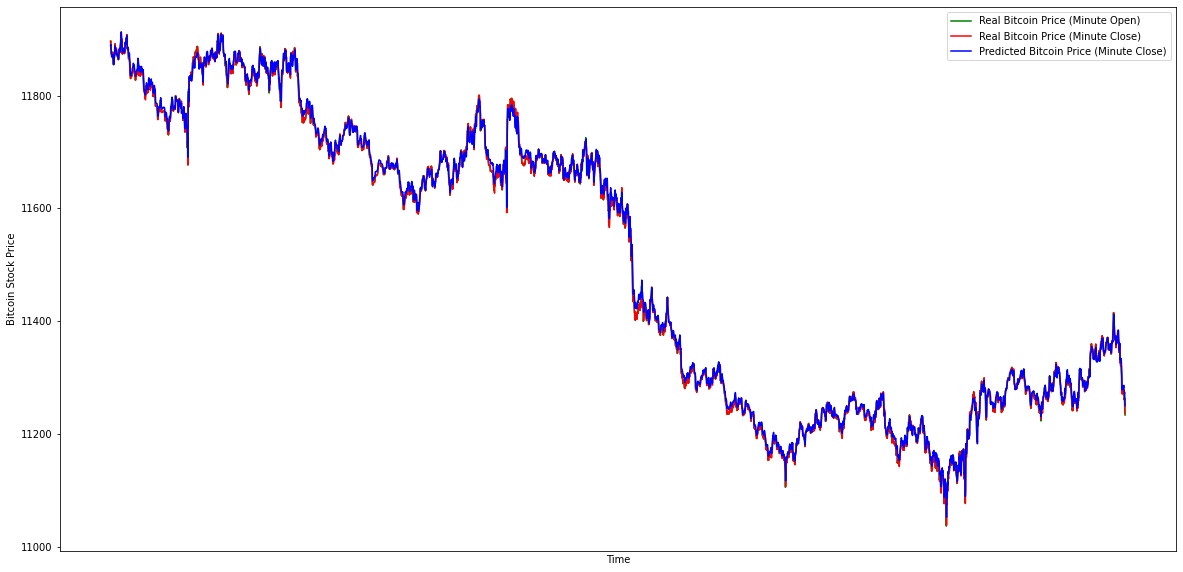

In [8]:
# Visualising the results
plt.figure(figsize=(20,10))

plt.plot(df.loc[num_train:, 'date'], df.iloc[num_train:, 1:2], color = 'green', label = 'Real Bitcoin Price (Minute Open)')
plt.plot(df.loc[num_train:, 'date'], df.iloc[num_train:, 4:5], color='red', label = 'Real Bitcoin Price (Minute Close)')
plt.plot(df.loc[num_train:, 'date'], predicted_padded[:,1], color = 'blue', label = 'Predicted Bitcoin Price (Minute Close)')

plt.xlabel('Time')
plt.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False)
plt.ylabel('Bitcoin Stock Price')
plt.legend()
plt.show()

In [10]:
error_sum = 0

for i in range(len(predicted_padded)):
    diff = abs(predicted_padded[i,1] - df.loc[num_train+i, 'close']) / df.loc[num_train+i, 'close']
    error_sum += diff

error_avg = error_sum / len(predicted_padded)
acc = 1 - error_avg
print(acc)

0.9996413305316978
